## Elastic Portal Frame Analysis with OpenSeesPy and Opsvis

Jupyter Notebook to accompany [tutorial article](https://www.engineeringskills.com/posts/building-a-parametric-frame-analysis-pipeline-with-openseespy-and-opsvis) on EngineeringSkills.com


**Dr Seán Carroll - [EngineeringSkills.com](https://www.engineeringskills.com)**

References
- [OpenSeesPy documentation](https://openseespydoc.readthedocs.io/en/latest/)
- [Opsvis documentation](https://opsvis.readthedocs.io/en/latest/index.html)

### Sample structure 
From Lecture 53 of [Beam and Frame Analysis using the Direct Stiffness Method in Python](https://www.engineeringskills.com/course/beam-and-frame-analysis-using-the-direct-stiffness-method-in-python)

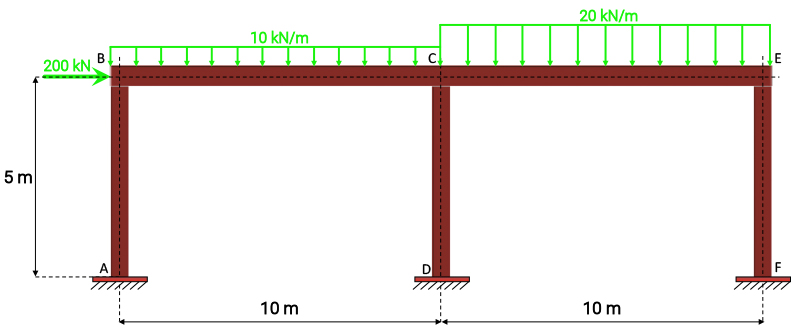

In [24]:
#OpenSeesPy and Opsvis
from openseespy.opensees import *
import opsvis as opsv #For OpenSeesPy visualisation

import math
import numpy as np
import matplotlib.pyplot as plt

## Structure Data Entry and Constants

In [25]:
#Constants
E = 200*10**9 #(N/m^2) Young'Modulus
A = 0.03 #0.01 #(m^2) Cross-sectional area
Iz = 300*10**-6 #(m^4) Second moment of area

#Geometry parameters
nBays = 2 #Number of bays
h_bay = 5 #(m) #Portal height
w_bay = 10 #(m) #Portal width

#Support fixity
fixity = (1,1,1) #Three degrees of freedom (Ux, Uy, theta_z) all fixed

## OpenSeesPy - Initialisation

In [26]:
# Remove any existing model from memory
wipe()

# Initialise the model - 2 dimensions and 3 degrees of freedom per node
model('basic', '-ndm', 2, '-ndf', 3)

## OpenSeesPy - Model Definition

### Nodes

In [27]:
#Cycle through columns and define nodes at base and eaves
for i in range(nBays+1):
    index=i+1 #Want iterator to start at 1 not zero (personal preference :)
    xCoord = i*w_bay

    #Base nodes
    nodeTag = (2*index)-1    
    yCoord = 0
    node(nodeTag, xCoord, yCoord)
    print(f'Base node with tag {nodeTag} defined')
    
    #Eaves nodes
    nodeTag = (2*index)
    yCoord = h_bay
    node(nodeTag, xCoord, yCoord)
    print(f'Eaves node with tag {nodeTag} defined')

Base node with tag 1 defined
Eaves node with tag 2 defined
Base node with tag 3 defined
Eaves node with tag 4 defined
Base node with tag 5 defined
Eaves node with tag 6 defined


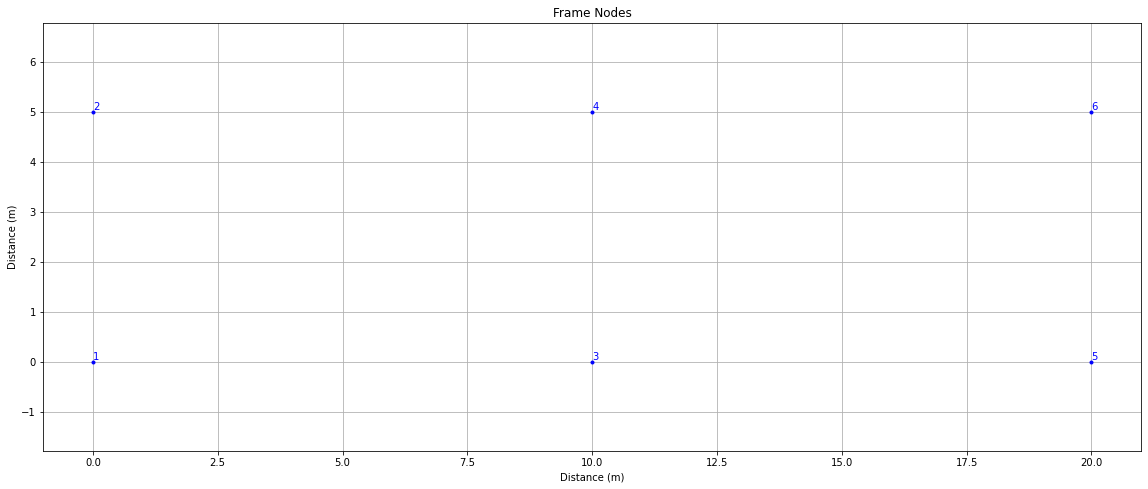

In [28]:
# Print model to confirm visually
def plotStructure(title):
    opsv.plot_model(fig_wi_he=(50,20)) #Pass in optional argument (fig_wi_he) to control plot size
    plt.title(title)
    plt.xlabel('Distance (m)')
    plt.ylabel('Distance (m)')
    plt.grid()
    plt.show()
    
plotStructure('Frame Nodes')

### Elements

Start by defining a linear transform object to map stiffness and actions from local to global reference frame. 2D model so default `Linear` transformn is sufficient [[Docs ref](https://openseespydoc.readthedocs.io/en/latest/src/geomTransf.html#geomTransf)].

We can optionally provide a vector specifying the orientation of the local z-axis in the global reference frame. So for our 2D model, the local z-axis for all elements aligns with the global z-axis. In this case the local z-vector `vecxz`, is [0,0,1]. Thus the following two commands yield the same transform:
- `geomTransf('Linear', transfTag)`
- `geomTransf(transfType, transfTag, 0,0,1)`

In [29]:
transfType = 'Linear'
transfTag = 1
geomTransf(transfType, transfTag)
# geomTransf(transfType, transfTag,0,0,1) #Same thing

Use `elasticBeamColumn` element [[Docs ref](https://openseespydoc.readthedocs.io/en/latest/src/elasticBeamColumn.html)]

In [30]:
#Define columns
for i in range(nBays+1):    
    eleTag = i+1
    endBottom = (2*eleTag)-1    
    endTop = (2*eleTag)    
    
    #Define element (elementType, elementTag, node_i, node_j, Area, YoungMod, Iz, transfTag)
    element('elasticBeamColumn', eleTag, endBottom, endTop, A, E, Iz, transfTag)
    print(f'Column element with tag {eleTag} defined')  
    
#Define rafters/beams
for i in range(nBays):  
    index = i+1    
    eleTag = nBays+1+index    
    endLeft = 2*index
    endRight = 2*index + 2
    
    element('elasticBeamColumn', eleTag, endLeft, endRight, A, E, Iz, transfTag)
    print(f'Rafter/Beam element with tag {eleTag} defined')      

Column element with tag 1 defined
Column element with tag 2 defined
Column element with tag 3 defined
Rafter/Beam element with tag 4 defined
Rafter/Beam element with tag 5 defined


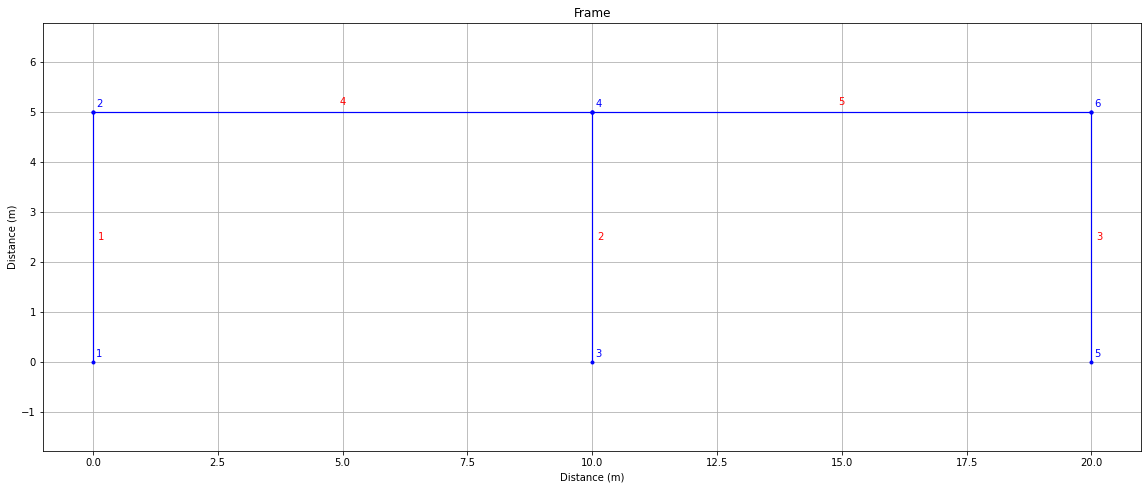

In [31]:
#Plot structure again to visually confirm
plotStructure('Frame')

### Supports

Supports are fixed, i.e. all degrees of freedom locked.

In [32]:
#Cycle through columns and define base fixity
for i in range(nBays+1):
    index=i+1 #Want iterator to start at 1 nor zero (preference)
    nodeTag = int((2*index)-1) #Base node    
    
    #Pre-append nodeTag to fixity tuple
    nodeFixity = (nodeTag,) + fixity
    
    #Unpack nodeFixity contents into argument for 'fix' method
    fix(*nodeFixity)

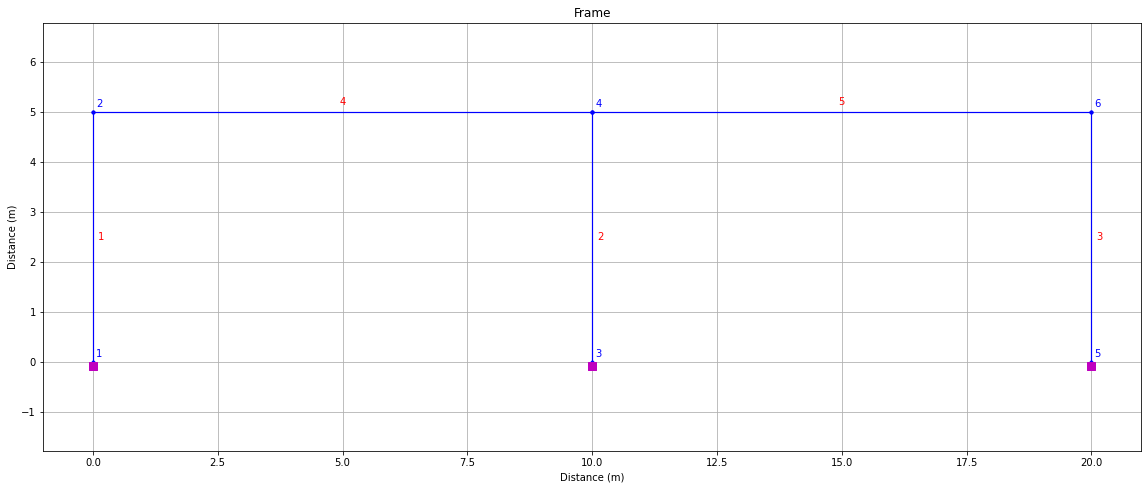

In [33]:
#Plot structure again to visually confirm
plotStructure('Frame')

## OpenSeesPy - Load Definition

### `TimeSeries` and `pattern`

In [34]:
# Create TimeSeries with a tag of 1
timeSeries("Constant", 1)

# Create a plain load pattern associated with the TimeSeries (pattern, patternTag, timeseriesTag)
pattern("Plain", 1, 1)

### Distributed Loads
Using the `eleLoad` command - [[Docs ref](https://openseespydoc.readthedocs.io/en/latest/src/eleload.html)]

In [35]:
eleLoad('-ele', 4, '-type', '-beamUniform', -10000) # 10kN/m on element 4
eleLoad('-ele', 5, '-type', '-beamUniform', -20000) # 20kN/m on element 5

### Nodal/Point Loads

In [36]:
#Point load applied to node 2 in the global X direction
load(2, 200000, 0., 0.)

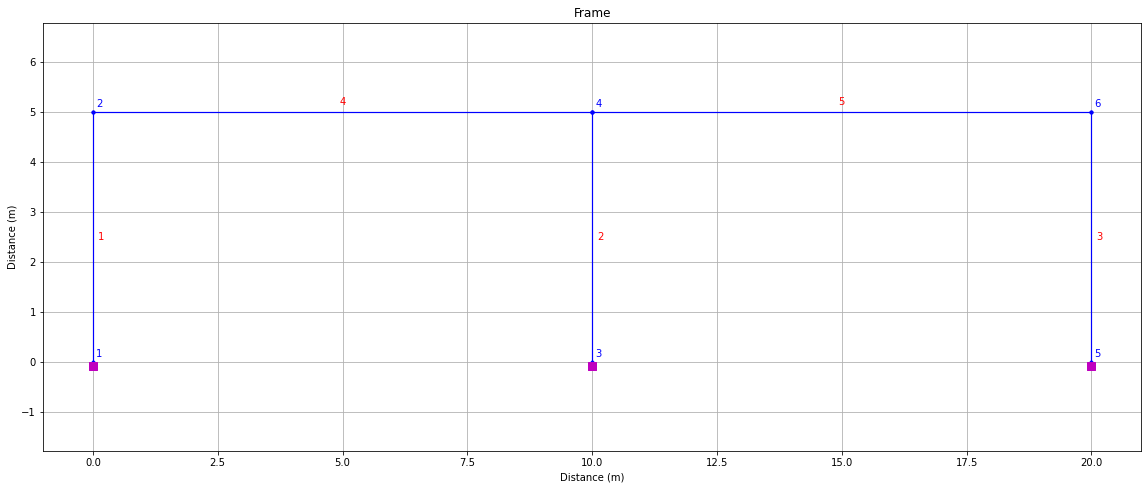

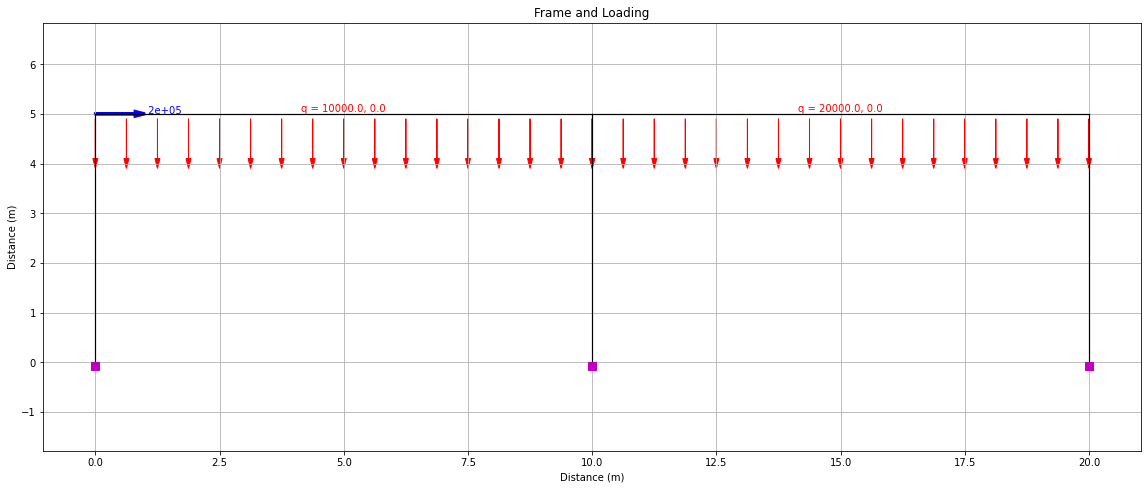

In [42]:
#Define a new function to plot loads
def plotLoads(title):
    opsv.plot_loads_2d(sfac=True, fig_wi_he=(50,20))
    plt.title(title)
    plt.xlabel('Distance (m)')
    plt.ylabel('Distance (m)')
    plt.grid()
    plt.show()

plotStructure('Frame')
plotLoads('Frame and Loading') #Execute this twice for the point load to show 🤷‍♂️

## OpenSees - Analysis

In [41]:
# Create SOE
system('BandGeneral') # BandGeneral more general solver than 'BandSPD'

# Create DOF number
numberer('RCM')

# Create constraint handler
constraints('Transformation')

# Create integrator
integrator('LoadControl', 1)

# Create algorithm
algorithm('Linear')

# Create analysis object
analysis('Static')

# Perform the analysis (with 1 analysis step)
analyze(1)

0

## Visualise results

### Deflection
Deflection is obtained using interpolation based on displacements and rotations at the end of each element

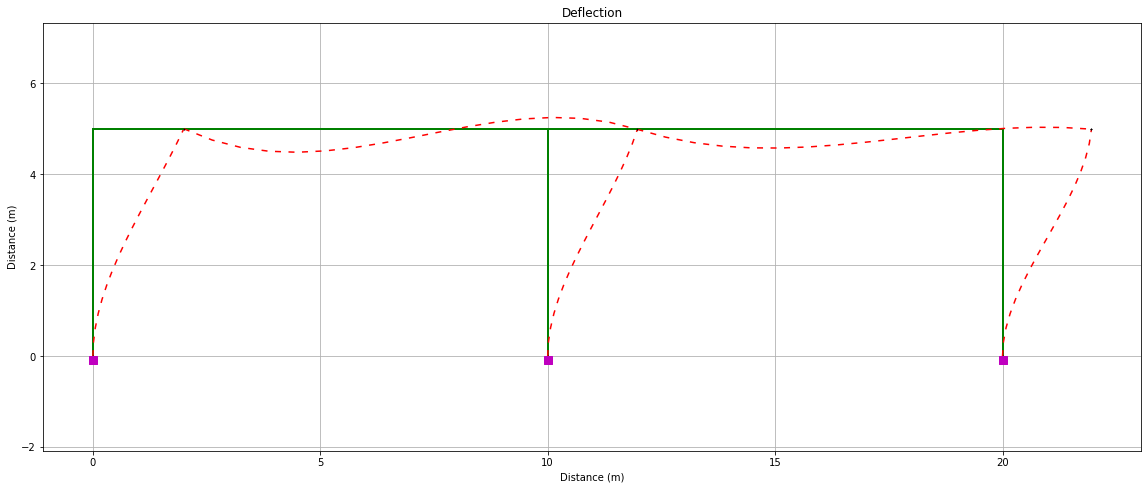

The scale factor on deflection is 107.35


In [43]:
s = opsv.plot_defo(fig_wi_he=(50,20), 
                   fmt_defo={'color': 'red', 'linestyle': (0, (4, 5)), 'linewidth': 1.5},
                   fmt_undefo={'color': 'green', 'linestyle': 'solid', 'linewidth': 2,},
                  )
plt.title('Deflection')
plt.xlabel('Distance (m)')
plt.ylabel('Distance (m)')
plt.grid()
plt.show()

print(f'The scale factor on deflection is {round(s,2)}')

### Bending moment

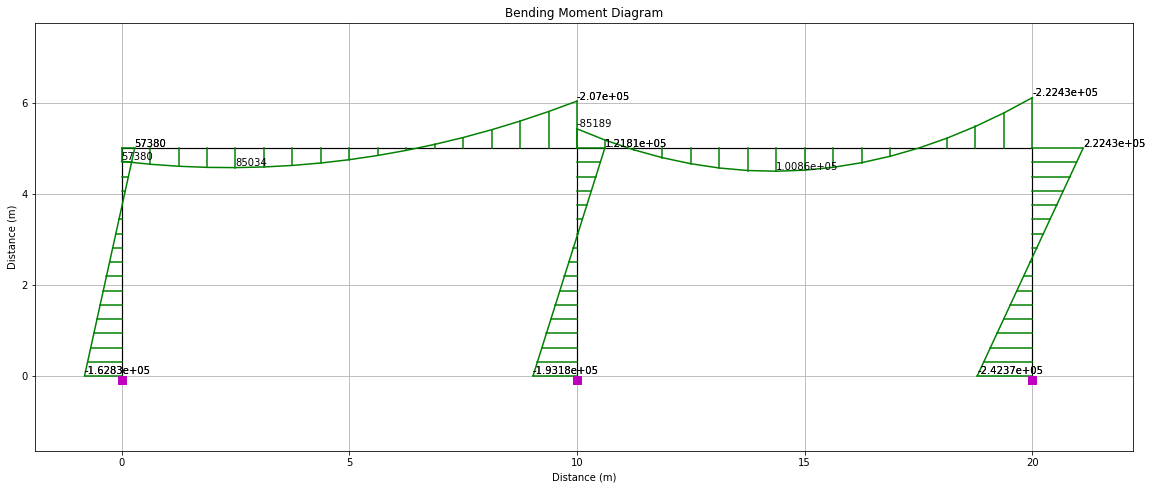

In [44]:
mFac = 5.e-6

opsv.section_force_diagram_2d('M', mFac, fig_wi_he=(50,20),
                             fmt_secforce1={'color': 'green'},
                             fmt_secforce2={'color': 'green'})

plt.title('Bending Moment Diagram')
plt.xlabel('Distance (m)')
plt.ylabel('Distance (m)')
plt.grid()
plt.show()

### Shear Force

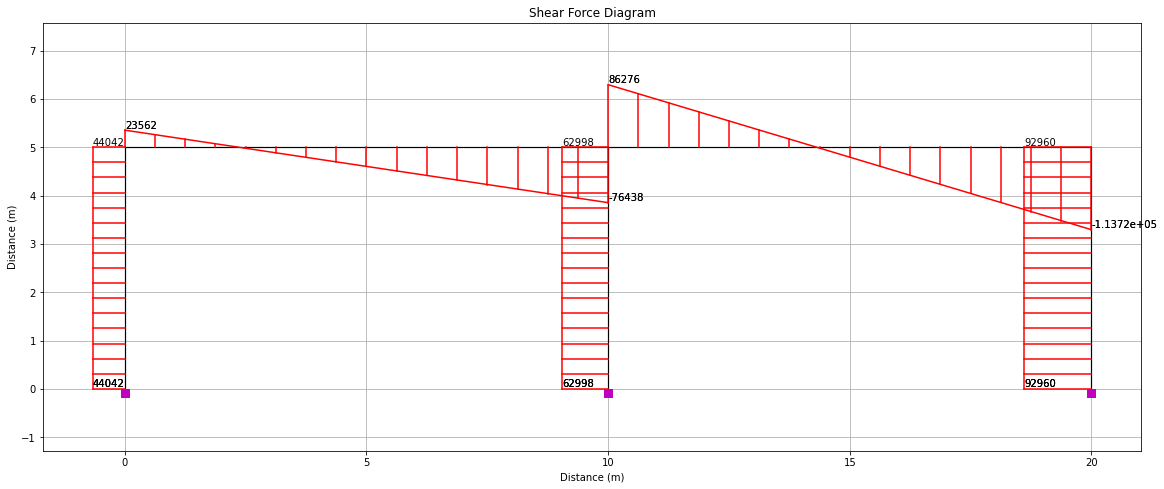

In [45]:
vFac = 15.e-6

opsv.section_force_diagram_2d('V', vFac, fig_wi_he=(50,20),
                             fmt_secforce1={'color': 'red'},
                             fmt_secforce2={'color': 'red'})

plt.title('Shear Force Diagram')
plt.xlabel('Distance (m)')
plt.ylabel('Distance (m)')
plt.grid()
plt.show()

### Axial Force

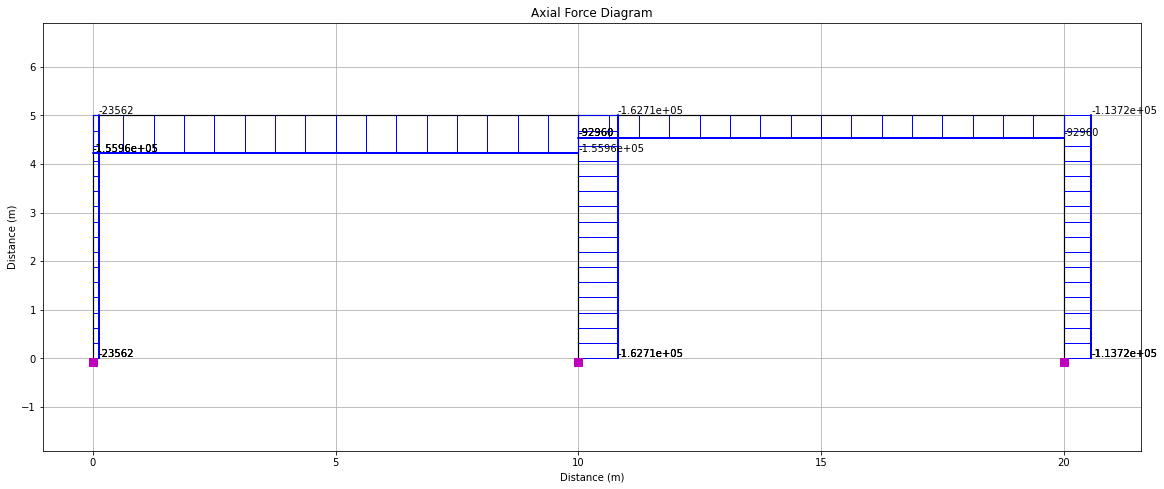

In [46]:
nFac = 5.e-6

opsv.section_force_diagram_2d('N', nFac, fig_wi_he=(50,20))

plt.title('Axial Force Diagram')
plt.xlabel('Distance (m)')
plt.ylabel('Distance (m)')
plt.grid()
plt.show()

In [47]:
# printModel()
printModel('-node',2)


 Node: 2
	Coordinates  : 0 5 
	Disps: 0.0186306 -1.96348e-05 -0.00439375 
	 unbalanced Load: 200000 0 0 
	ID : 6 7 8 

